In [1]:
# =========================
# 04_Model_Explainability_SHAP.ipynb
# SHAP-based interpretation for the final RandomForest model
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import shap

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

plt.style.use("seaborn-v0_8")
shap.initjs()

# -------------------------
# 1. Load processed NO-LEAK data
# -------------------------

DATA_PATH = "../data/processed/train_features_FD001_no_leak.csv"

df = pd.read_csv(DATA_PATH)
print("No-leak data shape:", df.shape)

target_col = "label"
X = df.drop(columns=[target_col])
y = df[target_col].values

# same chronological split as in 03
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    shuffle=False,
)

print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)


C:\Users\kvina\Documents\predictive_maintenance_project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No-leak data shape: (20631, 173)
X_train shape: (16504, 172)
X_test shape : (4127, 172)


In [2]:
# -------------------------
# 2. Train the final model (same hyperparams as in 03)
# -------------------------

final_model = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    n_jobs=-1,
    class_weight="balanced",
    random_state=42,
)

final_model.fit(X_train, y_train)

# Keep X_test for SHAP explanations


,n_estimators,400
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


X_sample shape: (400, 172)
Raw SHAP values shape: (400, 172, 2)
Using class-1 SHAP values, shape: (400, 172)


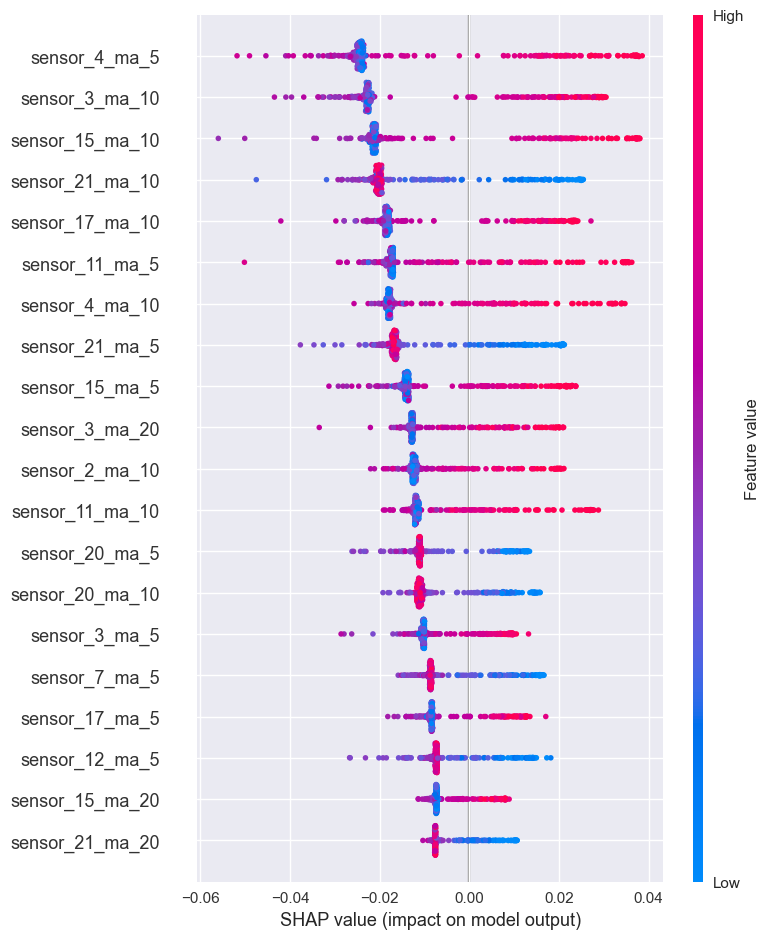

In [3]:
# -------------------------
# 3. SHAP global explanation (beeswarm summary plot)
# -------------------------

# Sample up to 400 rows from test set for speed
n_samples = min(400, len(X_test))
X_sample = X_test.sample(n=n_samples, random_state=42)

print("X_sample shape:", X_sample.shape)

explainer = shap.TreeExplainer(final_model)
shap_values_exp = explainer(X_sample, check_additivity=False)

# shap_values_exp is a shap.Explanation, get raw values
sv = shap_values_exp.values  # shape (n_samples, n_features) for binary RF (probability output)

print("Raw SHAP values shape:", sv.shape)

# Sometimes TreeExplainer returns (n_samples, n_features, n_classes)
if sv.ndim == 3:
    # pick class 1 (failure)
    sv = sv[:, :, 1]
    print("Using class-1 SHAP values, shape:", sv.shape)

assert sv.shape[0] == X_sample.shape[0]

plt.figure(figsize=(8, 10))
shap.summary_plot(sv, X_sample, max_display=20, show=True)


Top 10 features by mean |SHAP|:
            feature  mean_abs_shap
28    sensor_4_ma_5       0.024778
48   sensor_3_ma_10       0.022689
60  sensor_15_ma_10       0.022095
66  sensor_21_ma_10       0.019291
62  sensor_17_ma_10       0.018254
35   sensor_11_ma_5       0.017545
49   sensor_4_ma_10       0.017008
45   sensor_21_ma_5       0.016321
39   sensor_15_ma_5       0.014176
69   sensor_3_ma_20       0.012254

SHAP dependence for feature: sensor_4_ma_5


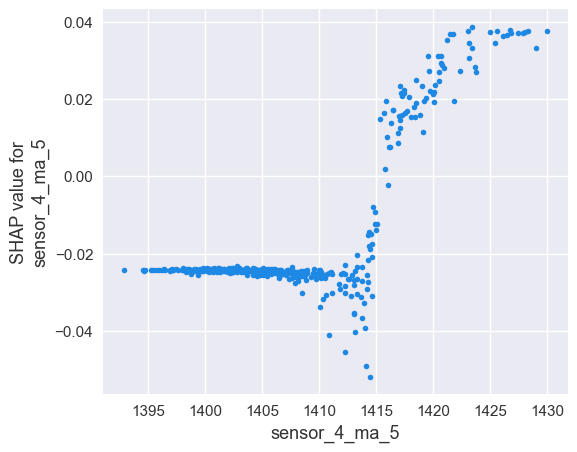


SHAP dependence for feature: sensor_3_ma_10


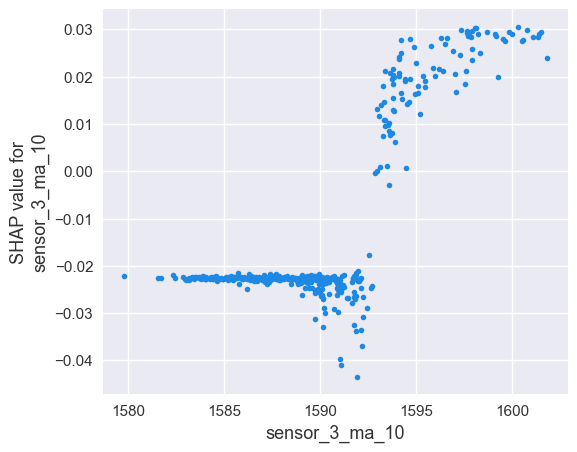


SHAP dependence for feature: sensor_15_ma_10


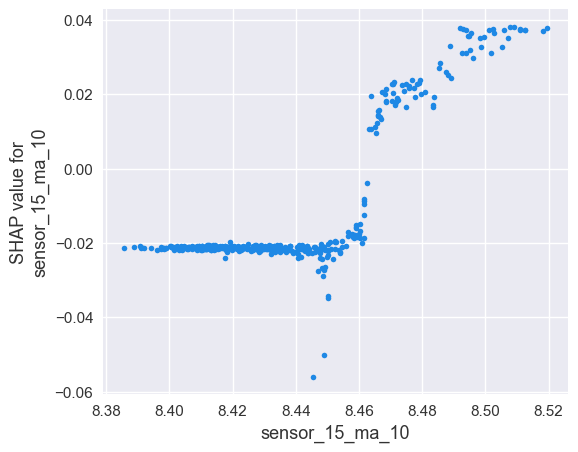

In [5]:
# -------------------------
# 4. SHAP dependence plot for top features
# -------------------------

# Approximate feature importance via mean |SHAP|
mean_abs_sv = np.mean(np.abs(sv), axis=0)
importance_df = pd.DataFrame({
    "feature": X_sample.columns,
    "mean_abs_shap": mean_abs_sv,
}).sort_values("mean_abs_shap", ascending=False)

print("Top 10 features by mean |SHAP|:")
print(importance_df.head(10))

# Take top 3 for dependence plots
top_feats = importance_df["feature"].head(3).tolist()

for feat in top_feats:
    print(f"\nSHAP dependence for feature: {feat}")
    shap.dependence_plot(
        feat,
        sv,
        X_sample,
        interaction_index=None,
        show=True,
    )


Prediction probability for this sample (class=1): 1.0


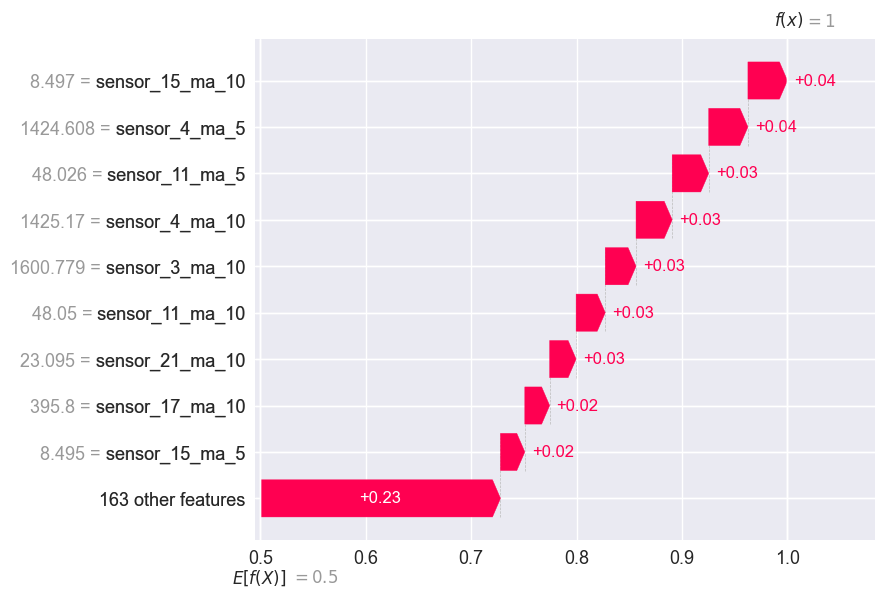

In [8]:
# -------------------------
# 5. Local explanation (waterfall plot for one failure-like example)
# -------------------------

# Find one sample where the model predicts a high failure probability
y_proba_test = final_model.predict_proba(X_test)[:, 1]

failure_idx = np.argsort(y_proba_test)[-1]  # most "risky" sample
x_single = X_test.iloc[[failure_idx]]

print("Prediction probability for this sample (class=1):", y_proba_test[failure_idx])

# Recompute SHAP for this single row
shap_single = explainer(x_single, check_additivity=False)

# If multi-class, take class 1
if shap_single.values.ndim == 3:
    shap_single_cls1 = shap.Explanation(
        values=shap_single.values[:, :, 1],
        base_values=shap_single.base_values[:, 1],
        data=shap_single.data,
        feature_names=shap_single.feature_names,
    )
else:
    shap_single_cls1 = shap_single

shap.plots.waterfall(shap_single_cls1[0], max_display=10)
